In [1]:
%config IPCompleter.greedy=True;

In [2]:
"""
TODOs:
    0. % TODO(Moravec): rok,mesic,den v tydnu jako kategorialni pro binarizaci
    1. Explore pm2.5 by days
    2. Generally explore values by days.
"""

'\nTODOs:\n    0. % TODO(Moravec): rok,mesic,den v tydnu jako kategorialni pro binarizaci\n    1. Explore pm2.5 by days\n    2. Generally explore values by days.\n'

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
from timeit import default_timer as timer

In [160]:
dataFile = "../data/beijing_pm25.csv"

In [161]:
# Read data file.
df = pd.read_csv(dataFile,sep=',')
originalCount = df.shape[0]
# Drop rows with NaN values in target column pm2.5
sizeBefore = df.shape[0]
df = df.dropna()
nanCount = sizeBefore - df.shape[0]
print(f"Initial dataset with {df.shape[0]} rows (originally {originalCount}) and {df.shape[1]} columns, dropped {nanCount} NaN rows")

Initial dataset with 41757 rows (originally 43824) and 13 columns, dropped 2067 NaN rows


In [162]:
# Add week days column
dates = pd.to_datetime(df[["day", "month","year", "hour"]])
week_days = [d.isoweekday() for d in dates]
df["week_day"] = week_days

In [163]:
# Drop No column which is just ID and reorganize columns 
df = df[["week_day","day", "month", "year", "hour", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir", "pm2.5"]]
# Rename columns to sensible names
df = df.rename({
    "DEWP": "dew_point", 
    "TEMP": "temperature", 
    "PRES": "pressure",
    "cbwd": "wind_direction",
    "Iws": "wind_speed",
    "Is": "hours_snow",
    "Ir": "hours_rain"}, axis=1)

In [164]:
# Columns statistics
df.describe()

,week_day,day,month,year,hour,dew_point,temperature,pressure,wind_speed,hours_snow,hours_rain,pm2.5
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,4.001892,15.685514,6.513758,2012.042771,11.502311,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866,98.613215
std,1.994789,8.785539,3.454199,1.415311,6.924848,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165,92.050387
min,1.000000,1.000000,1.000000,2010.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,4.000000,2011.000000,5.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,29.000000
50%,4.000000,16.000000,7.000000,2012.000000,12.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,72.000000
75%,6.000000,23.000000,10.000000,2013.000000,18.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,137.000000
max,7.000000,31.000000,12.000000,2014.000000,23.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000,994.000000


In [165]:
def boxplot_for_group(groupColumns, plotTitle, showOutliers=False, pdfFile=None):
    bpData = []
    xTics = []
    for (name, group) in df.groupby(groupColumns):
        xTics.append(name)
        bpData.append(group["pm2.5"])

    # Multiple box plots on one Axes
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(plotTitle)

    ax.boxplot(bpData, showfliers=showOutliers)
    ax.set_xticklabels(xTics)

    if pdfFile != None:
        plt.savefig(pdfFile)
    else:
        plt.show()

In [166]:
def boxplot_for_year_group(groupColumns, plotTitle, showOutliers=False, pdfFile=None):
    
    fig, axs = plt.subplots(5, figsize=(20,20),sharey=True)
    #ax1.plot(x, y)
    #ax2.plot(x, -y)
    index=0
    
    for (yName,yGroup) in df.groupby(["year"]):
        bpData = []
        xTics = []
        for (name, group) in yGroup.groupby(groupColumns):
            xTics.append(name)
            bpData.append(group["pm2.5"])

        #fig, ax = plt.subplots(figsize=(15,5))
        axs[index].set_title(yName)
        axs[index].boxplot(bpData, showfliers=showOutliers)
        axs[index].set_xticklabels(xTics)
        index += 1
        
    #axs.tight_layout()
    fig.tight_layout()

    if pdfFile != None:
        plt.savefig(pdfFile)
    else:
        plt.show()

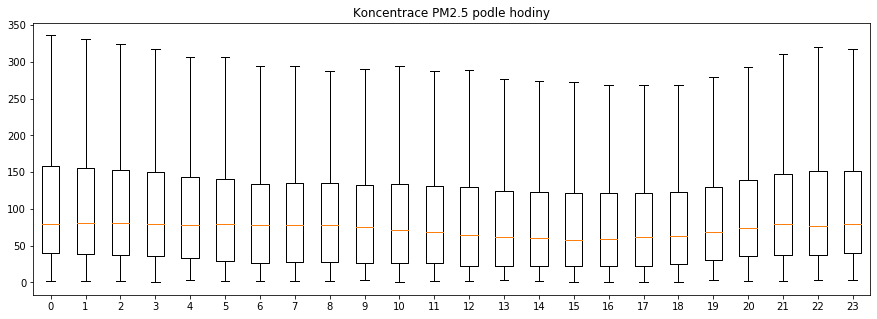

In [167]:
#boxplot_for_group(["year"],"Koncentrace PM2.5 podle roku", showOutliers=False, pdfFile="target_by_year.pdf")
boxplot_for_group(["hour"],"Koncentrace PM2.5 podle hodiny", showOutliers=False, pdfFile="target_by_hour.pdf")
#boxplot_for_year_group(["month"], "Koncentrace PM2.5 podle mesicu v rocich", showOutliers=False, pdfFile="target_by_month_by_year.pdf")

In [168]:
# Week day analysis
weekDaysDf = pd.DataFrame(df["week_day"].value_counts())
weekDaysDf = weekDaysDf.sort_index()
weekDaysDf
# df["week_day"].hist(bins=7)

,week_day
1,5923
2,5932
3,5989
4,6011
5,6019
6,5967
7,5916


<BarContainer object of 7 artists>

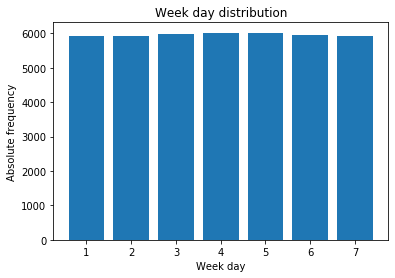

In [169]:
plt.title("Week day distribution")
plt.xlabel("Week day")
plt.ylabel("Absolute frequency")
plt.bar(weekDaysDf.index.values, weekDaysDf.week_day.values)

In [60]:
# Month analysis
monthDf = pd.DataFrame(df["month"].value_counts())
monthDf = monthDf.sort_index()
monthDf

,month
1,3471
2,3373
3,3556
4,3405
5,3609
6,3405
7,3647
8,3337
9,3333
10,3579


<BarContainer object of 12 artists>

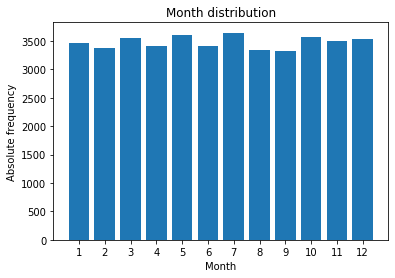

In [61]:
plt.title("Month distribution")
plt.xlabel("Month")
plt.ylabel("Absolute frequency")
plt.xticks(monthDf.index.values)
plt.bar(monthDf.index.values, monthDf.month.values)

In [62]:
# Year analysis
yearDf = pd.DataFrame(df["year"].value_counts())
yearDf = yearDf.sort_index()
yearDf

,year
2010,8091
2011,8032
2012,8295
2013,8678
2014,8661


<BarContainer object of 5 artists>

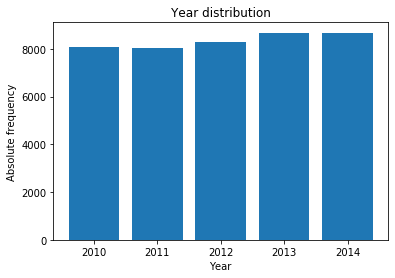

In [63]:
plt.title("Year distribution")
plt.xlabel("Year")
plt.ylabel("Absolute frequency")
plt.xticks(yearDf.index.values)
plt.bar(yearDf.index.values, yearDf.year.values)

In [127]:
# Wind direction analysis
#set(df["wind_direction"])
windDirDf = pd.DataFrame(df["wind_direction"].value_counts())
windDirDf = windDirDf.sort_index()
windDirDf

,wind_direction
NE,4756
NW,13484
SE,14573
cv,8944


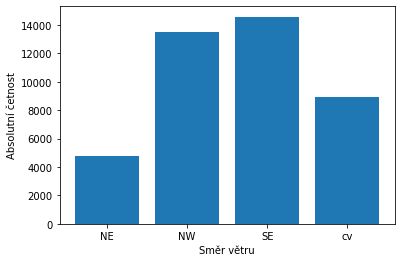

In [136]:
# plt.title("Absolut")
plt.xlabel("Směr větru")
plt.ylabel("Absolutní četnost")
#plt.set_xticklabels(["a","b","c","d"])
plt.bar(windDirDf.index.values,windDirDf.wind_direction.values)
plt.savefig("wind_dir_dist.pdf")

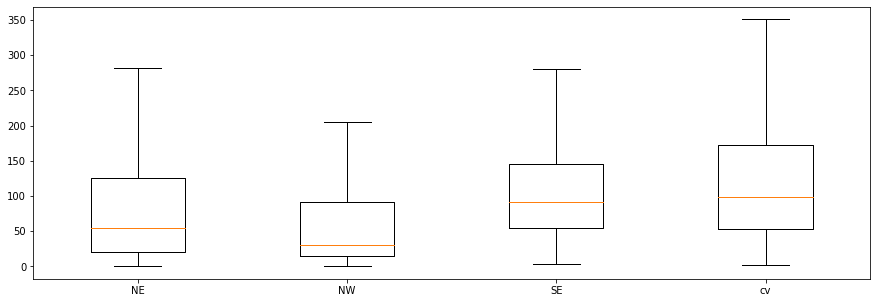

In [138]:
boxplot_for_group(["wind_direction"], "", pdfFile="target_by_wind_dir.pdf")

In [170]:
def outlier_count(boxplot_object):    
    assert len(boxplot_object["fliers"]) == 1
    yData =  boxplot_object["fliers"][0].get_ydata()
    outlierCount = len(yData)
    return outlierCount

dew_point outlier count 0 out of 41757
temperature outlier count 0 out of 41757
pressure outlier count 0 out of 41757
wind_speed outlier count 4893 out of 41757
hours_snow outlier count 368 out of 41757
hours_rain outlier count 1739 out of 41757
pm2.5 outlier count 1773 out of 41757


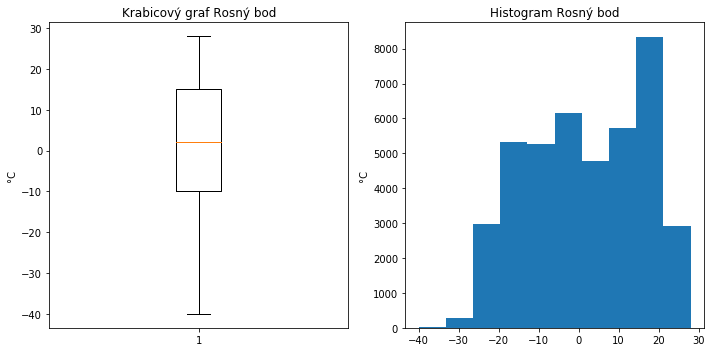

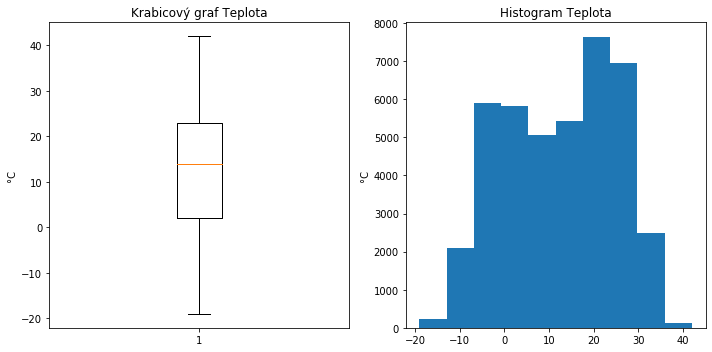

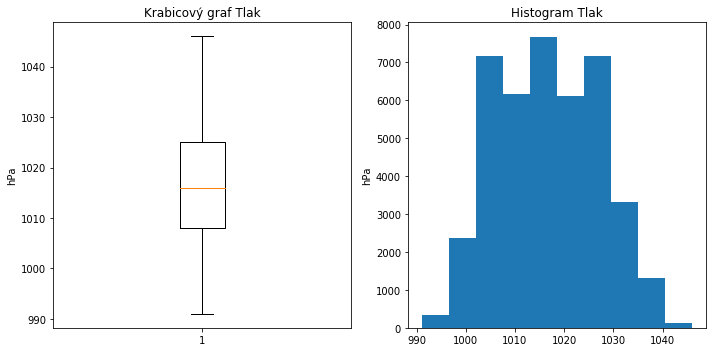

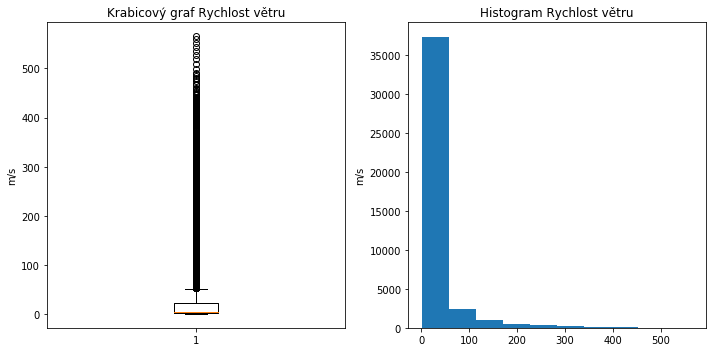

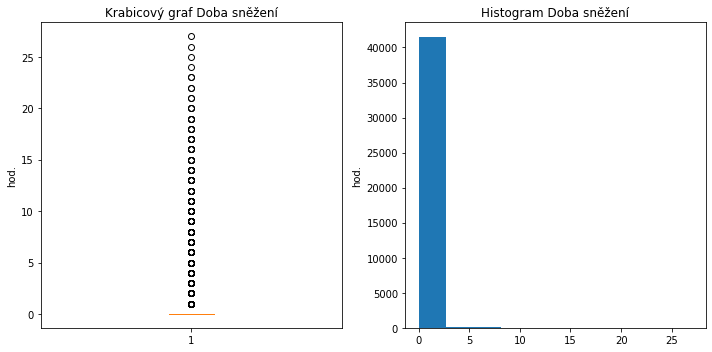

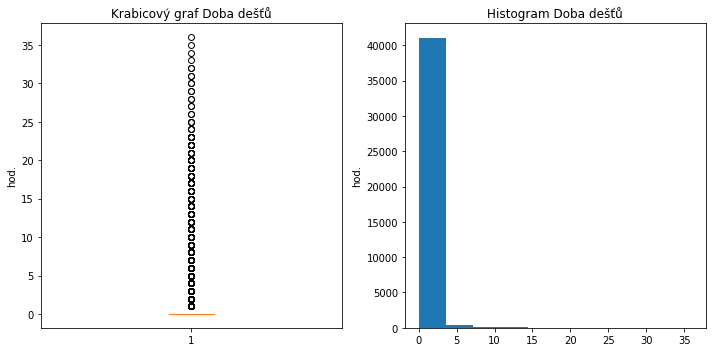

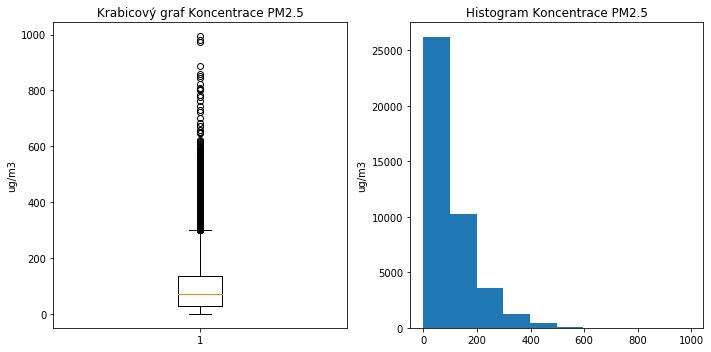

In [171]:
# Histogram / Box plot outlier analysis

names = ["Rosný bod", "Teplota", "Tlak", "Rychlost větru", "Doba sněžení", "Doba dešťů", "Koncentrace PM2.5"]
units =  [ "°C", "°C", "hPa", "m/s", "hod.", "hod.", "ug/m3" ]
pdfFiles = ["dewpt.pdf","temp.pdf","press.pdf","wndspd.pdf","hsnow.pdf","hrain.pdf","pm25.pdf"]
index=0
for c in ["dew_point", "temperature", "pressure", 
          "wind_speed", "hours_snow", "hours_rain", 
          "pm2.5" ]:
    
    data = df[c]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title("Krabicový graf " + names[index])
    plt.ylabel(units[index])
    boxPlotObject = plt.boxplot(data, showfliers=True)
    
    plt.subplot(1, 2, 2)
    plt.title("Histogram " + names[index])
    plt.ylabel(units[index])
    plt.hist(data)
    
    totalCount = len(data)
    outlierCount = outlier_count(boxPlotObject)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(pdfFiles[index])
    print(f"{c} outlier count {outlierCount} out of {totalCount}")
    index += 1

In [144]:
def print_outliers(dataFrame, column):
    q1 = dataFrame[column].quantile(0.25)
    q3 = dataFrame[column].quantile(0.75)
    iqr = q3 - q1
    hint = dataFrame[column].between( (q1 - (1.5 * iqr)), (q3 + (1.5 * iqr)) )
    
    return [ x[0] for x in zip(dataFrame[column], hint) if x[1] == False ]

In [151]:
def remove_outliers(dataFrame, columns):
    for column in columns:
        q1 = dataFrame[column].quantile(0.25)
        q3 = dataFrame[column].quantile(0.75)
        iqr = q3 - q1
        hint = dataFrame[column].between( (q1 - (1.5 * iqr)), (q3 + (1.5 * iqr)) )
        
        newColumnValues = [ (x[0] if x[1] else np.NaN ) for x in zip(dataFrame[column], hint) ]
        dataFrame[column] = newColumnValues
        #inCount = len(dataFrame[column][hint])
        #removedCount = len(dataFrame[column]) - inCount
        #print(f"Removing {removedCount} from col: {column}")

In [173]:
before = df.shape
print(f"Shape before {before}")
remove_outliers(df, ["pm2.5"])
df = df.dropna()
removed = before[0] - df.shape[0]
print(f"Removed {removed} rows because of pm2.5 outliers")
print(f"Shape after {df.shape}")

Shape before (41757, 13)
Removed 1773 rows because of pm2.5 outliers
Shape after (39984, 13)


In [176]:
# HERE WE HAVE df WITHOUT pm2.5 outliers
# WE ALSO CREATE df_no_outliers without any outlier
df_no_outliers = df.copy(deep=True)
before = df_no_outliers.shape
print(f"Shape before {before}")
remove_outliers(df_no_outliers,["wind_speed","hours_snow","hours_rain"])
df_no_outliers = df_no_outliers.dropna()
removedCnt = before[0] - df_no_outliers.shape[0]
print(f"Shape after {df_no_outliers.shape}\nRemoved {removedCnt} rows")

Shape before (39984, 13)
Shape after (33512, 13)
Removed 6472 rows


In [221]:
# Final datasets
df_binAll = pd.get_dummies(df, columns=["hour","week_day","day","month","year", "wind_direction"])
df_binAll_gt = df_binAll["pm2.5"].values
df_binAll.drop(columns=["pm2.5"], inplace=True)
assert (df_binAll.shape[0] == len(df_binAll_gt))

df_binNoDay = pd.get_dummies(df.drop(columns=["day"], axis=1), columns=["hour","week_day","month","year", "wind_direction"])
df_binNoDay_gt = df_binNoDay["pm2.5"].values
df_binNoDay.drop(columns=["pm2.5"], inplace=True)
assert (df_binNoDay.shape[0] == len(df_binNoDay_gt))

df_noOut_binNoDay = pd.get_dummies(df_no_outliers.drop(columns=["day"], axis=1), columns=["hour","week_day","month","year", "wind_direction"])
df_noOut_binNoDay_gt = df_noOut_binNoDay["pm2.5"].values
df_noOut_binNoDay.drop(columns=["pm2.5"], inplace=True)
assert (df_noOut_binNoDay.shape[0] == len(df_noOut_binNoDay_gt))

scaler = MinMaxScaler((0.0, 1.0))
df_binAll = pd.DataFrame(scaler.fit_transform(df_binAll))
df_binNoDay = pd.DataFrame(scaler.fit_transform(df_binNoDay))
df_noOut_binNoDay = pd.DataFrame(scaler.fit_transform(df_noOut_binNoDay))

df_noOut_binNoDay_20attr = pd.DataFrame(PCA(n_components=20).fit_transform(df_noOut_binNoDay))
assert (df_noOut_binNoDay_20attr.shape[0] == len(df_noOut_binNoDay_gt))
assert (df_noOut_binNoDay_20attr.shape[1] == 20)

df_noOut_binNoDay_10attr = pd.DataFrame(PCA(n_components=10).fit_transform(df_noOut_binNoDay))
assert (df_noOut_binNoDay_10attr.shape[0] == len(df_noOut_binNoDay_gt))
assert (df_noOut_binNoDay_10attr.shape[1] == 10)

In [223]:
print(f"Final datasets:\n    df_binAll\t\t{df_binAll.shape} - all date/times columns binarization, no pm2.5 outliers")
print(f"    df_binNoDay\t\t{df_binNoDay.shape} - removed day column, rest of date/times columns binarization, no pm2.5 outliers")
print(f"    df_noOut_binNoDay\t{df_noOut_binNoDay.shape} - removed day column, date/times binarization, all outliers removed")
print(f"    df_noOut_binNoDay_20attr\t{df_noOut_binNoDay_20attr.shape} - 20 attributes (PCA), removed day column, date/times binarization, all outliers removed")
print(f"    df_noOut_binNoDay_10attr\t{df_noOut_binNoDay_10attr.shape} - 10 attributes (PCA), removed day column, date/times binarization, all outliers removed")

Final datasets:
    df_binAll		(39984, 89) - all date/times columns binarization, no pm2.5 outliers
    df_binNoDay		(39984, 58) - removed day column, rest of date/times columns binarization, no pm2.5 outliers
    df_noOut_binNoDay	(33512, 58) - removed day column, date/times binarization, all outliers removed
    df_noOut_binNoDay_20attr	(33512, 20) - 20 attributes (PCA), removed day column, date/times binarization, all outliers removed
    df_noOut_binNoDay_10attr	(33512, 10) - 10 attributes (PCA), removed day column, date/times binarization, all outliers removed


In [214]:
df_binAll

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,0.352941,0.245902,0.527273,0.002372,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.367647,0.245902,0.527273,0.003947,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.426471,0.229508,0.545455,0.005522,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.485294,0.229508,0.563636,0.008690,0.037037,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.485294,0.229508,0.563636,0.010265,0.074074,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.485294,0.213115,0.563636,0.011840,0.111111,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.485294,0.213115,0.581818,0.015008,0.148148,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.485294,0.229508,0.600000,0.018176,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.470588,0.213115,0.600000,0.021344,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.485294,0.229508,0.618182,0.024512,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
